In [1]:
# 🛠️ Day 12: Basic Feature Engineering
# Author: David Caleb Chaparro Orozco
# Topic: Creating, Transforming, and Encoding Features for Machine Learning Models

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Set style for plots
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Create directories if they don't exist
os.makedirs("outputs", exist_ok=True)
os.makedirs("data", exist_ok=True)

## 1. Load and Explore Datasets

In [2]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Load the latest version
data = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "rohitsahoo/sales-forecasting",
    "train.csv",
    pandas_kwargs={"encoding": "latin1"}
)
data.head()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_30320\596225501.py:5: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  data = kagglehub.load_dataset(


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


## 2. Initial Exploration

In [3]:
# Check a overview of the dataset
def overview(data):
    print("=".center(50,"="))

    # Print the shape of the dataset to see how many rows and columns it has.
    print(f"\nSales Forecasting Overview")
    print(f"Shape: {data.shape}")
    print(f"Memory Usage: {data.memory_usage().sum()/1024/1024:.2f} MB")
    print("=".center(50,"="))

    # Display Index, Columns, and Data Types
    print("Information about the features:")
    print(data.info())
    print("=".center(50,"="))
    dtype_counts = data.dtypes.value_counts()
    for dtype, count in dtype_counts.items():
        print(f"{str(dtype):<20}: {count} columns")
    print("=".center(50,"="))

    # Display summary statistics
    print("Basic statistics check:")
    print(data.describe())
    print("=".center(50,"="))

    # I always run this part to understand the unique values in each column.
    # It helps me get a sense of the data, especially which features are categorical or have low variability.
    print("Checking the number of unique values:")
    unique_counts = {}
    for column in data.columns:
        unique_counts[column] = data[column].nunique()
    unique_data = pd.DataFrame(unique_counts, index=["Unique Count"]).transpose()
    print(unique_data)
    print("=".center(50, "="))

    # Check for Missing Values
    print("Check for missing values:")
    missing_values = data.isnull().sum()
    missing_pct = (missing_values / len(data)) * 100
    missing_data = pd.DataFrame({
        'Missing Values': missing_values,
        'Percentage (%)': missing_pct.round(2)
    })
    print(missing_data[missing_data['Missing Values'] > 0])
overview(data)


Sales Forecasting Overview
Shape: (9800, 18)
Memory Usage: 1.35 MB
Information about the features:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 

In [4]:
# Display column names of the dataset
data.columns.values

array(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City',
       'State', 'Postal Code', 'Region', 'Product ID', 'Category',
       'Sub-Category', 'Product Name', 'Sales'], dtype=object)

## 3. Data Cleaning & Preparation
Handling inconsistencies and preparing data for analysis.  

**Analogy**: *Like washing vegetables before cooking*  
- Remove dirt (missing values)  
- Trim unusable parts (outliers in Sales)  
- Standardize sizes (consistent column naming)  
- Some veggies need special cleaning (postal codes filled by city groups)

In [5]:
def to_camel_case(name: str) -> str:
    parts = name.replace("-", " ").replace("_", " ").split()
    camel_parts = []
    for p in parts:
        if p.isupper():
            camel_parts.append(p)
        else:
            camel_parts.append(p.capitalize())
    return "".join(camel_parts)

In [6]:
def data_cleaning(data):
    # Make a copy of the original data to preserve it
    data_cleaned = data.copy()
    initial_rows = len(data_cleaned)

    print("=".center(50, "="))
    print("Data Cleaning Overview")
    print("Original data:")
    print(data_cleaned.head())
    print("=".center(50, "="))

    # Drop missing values
    print("Dropping missing values")
    data_cleaned = data_cleaned.dropna()
    print("After dropping missing values:")
    print(data_cleaned.head())
    print("=".center(50, "="))

    # Fill remaining missing values with a constant
    print("Filling any remaining missing values with 'Unknown'")
    categorical_cols = data_cleaned.select_dtypes(include=['object']).columns
    data_cleaned[categorical_cols] = data_cleaned[categorical_cols].fillna("Unknown")
    print("After filling missing values:")
    print(data_cleaned.head())
    print(f"Removed {initial_rows - len(data_cleaned)} rows with missing critical data")
    print("=".center(50, "="))

    # Rename columns automatically to CamelCase with preserved acronyms
    print("Renaming columns to CamelCase (preserving acronyms)")
    data_cleaned.columns = [to_camel_case(col) for col in data_cleaned.columns]
    print("After renaming columns:")
    print(data_cleaned.head())
    print("=".center(50, "="))

    print("\nFinal cleaned data preview:")
    print("- Remaining missing values:", data_cleaned.isnull().sum().sum())
    print("- New shape:", data_cleaned.shape)
    display(data_cleaned.head())

    return data_cleaned

cleaned_data = data_cleaning(data)

Data Cleaning Overview
Original data:
   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
1       2  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
2       3  CA-2017-138688  12/06/2017  16/06/2017    Second Class    DV-13045   
3       4  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   
4       5  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   

     Customer Name    Segment        Country             City       State  \
0      Claire Gute   Consumer  United States        Henderson    Kentucky   
1      Claire Gute   Consumer  United States        Henderson    Kentucky   
2  Darrin Van Huff  Corporate  United States      Los Angeles  California   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   

   Postal Co

,RowID,OrderID,OrderDate,ShipDate,ShipMode,CustomerID,CustomerName,Segment,Country,City,State,PostalCode,Region,ProductID,Category,SubCategory,ProductName,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [7]:
print(cleaned_data.isnull().sum())

RowID           0
OrderID         0
OrderDate       0
ShipDate        0
ShipMode        0
CustomerID      0
CustomerName    0
Segment         0
Country         0
City            0
State           0
PostalCode      0
Region          0
ProductID       0
Category        0
SubCategory     0
ProductName     0
Sales           0
dtype: int64


## 4. Feature Engineering

### 4.1 Date Features
Extracting temporal patterns from timestamps.

**Analogy**: *Like analyzing a school calendar*  
- Semester (year), month (periodic cycles), and weekday (routine patterns) matter  
- Holidays create spikes (special dates affect sales)  
- Duration between events (order-to-ship days) shows efficiency

In [8]:
# Convert date columns to datetime
cleaned_data['OrderDate'] = pd.to_datetime(cleaned_data['OrderDate'], format='%d/%m/%Y')
cleaned_data['ShipDate'] = pd.to_datetime(cleaned_data['ShipDate'], format='%d/%m/%Y')

# Extract date components
cleaned_data['OrderYear'] = cleaned_data['OrderDate'].dt.year
cleaned_data['OrderMonth'] = cleaned_data['OrderDate'].dt.month
cleaned_data['OrderDay'] = cleaned_data['OrderDate'].dt.day
cleaned_data['OrderWeekday'] = cleaned_data['OrderDate'].dt.weekday
cleaned_data['OrderQuarter'] = cleaned_data['OrderDate'].dt.quarter

# Calculate shipping duration
cleaned_data['ShippingDuration'] = (cleaned_data['ShipDate'] - cleaned_data['OrderDate']).dt.days

# Display new date features
cleaned_data[['OrderDate', 'ShipDate', 'OrderYear', 'OrderMonth', 'OrderDay', 
        'OrderWeekday', 'OrderQuarter', 'ShippingDuration']].head()

,OrderDate,ShipDate,OrderYear,OrderMonth,OrderDay,OrderWeekday,OrderQuarter,ShippingDuration
0,2017-11-08,2017-11-11,2017,11,8,2,4,3
1,2017-11-08,2017-11-11,2017,11,8,2,4,3
2,2017-06-12,2017-06-16,2017,6,12,0,2,4
3,2016-10-11,2016-10-18,2016,10,11,1,4,7
4,2016-10-11,2016-10-18,2016,10,11,1,4,7


### 4.2 Encoding
Converting text to numbers while preserving meaning.  

**Analogy**: *Like translating languages*  
- Simple words use direct translation (Label Encoding for Segment)  
- Complex concepts need explanations (One-Hot for ShipMode)  
- Local slang requires context (Target Encoding for City)

In [9]:
# One-Hot Encoding for 'ShipMode'
ship_mode_encoded = pd.get_dummies(cleaned_data['ShipMode'], prefix='ShipMode', prefix_sep='')
ship_mode_encoded.columns = ship_mode_encoded.columns.str.replace(" ", "")
cleaned_data = pd.concat([cleaned_data, ship_mode_encoded], axis=1)

# Label Encoding for 'Segment'
label_encoder = LabelEncoder()
cleaned_data['SegmentEncoded'] = label_encoder.fit_transform(cleaned_data['Segment'])

# Frequency Encoding for 'City'
city_freq = cleaned_data['City'].value_counts(normalize=True)
cleaned_data['CityFreqEncoded'] = cleaned_data['City'].map(city_freq)

# Display encoded features
cleaned_data[['ShipMode', 'ShipModeFirstClass', 'ShipModeSecondClass', 
        'ShipModeStandardClass', 'Segment', 'SegmentEncoded', 
        'City', 'CityFreqEncoded']].head()

,ShipMode,ShipModeFirstClass,ShipModeSecondClass,ShipModeStandardClass,Segment,SegmentEncoded,City,CityFreqEncoded
0,Second Class,False,True,False,Consumer,0,Henderson,0.005210
1,Second Class,False,True,False,Consumer,0,Henderson,0.005210
2,Second Class,False,True,False,Corporate,1,Los Angeles,0.074369
3,Standard Class,False,False,True,Consumer,0,Fort Lauderdale,0.001328
4,Standard Class,False,False,True,Consumer,0,Fort Lauderdale,0.001328


### 4.3 Transformations
Adjusting feature distributions for modeling.  

**Analogy**: *Like normalizing workout intensities*  
- Log transform squashes extreme weights (heavy sales outliers)  
- Scaling puts all exercises in 0-1 range (MinMax)  
- Percentile ranking shows relative performance

In [10]:
# Log transformation for 'Sales' (to handle skewness)
cleaned_data['SalesLog'] = np.log1p(cleaned_data['Sales'])

# Binning 'Sales' into categories
cleaned_data['SalesBinned'] = pd.qcut(cleaned_data['Sales'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

# Standard Scaling
scaler = StandardScaler()
cleaned_data['SalesScaled'] = scaler.fit_transform(cleaned_data[['Sales']])

# Min-Max Scaling
minmax_scaler = MinMaxScaler()
cleaned_data['SalesMinmax'] = minmax_scaler.fit_transform(cleaned_data[['Sales']])

# Display transformed features
cleaned_data[['Sales', 'SalesLog', 'SalesBinned', 'SalesScaled', 'SalesMinmax']].head()

,Sales,SalesLog,SalesBinned,SalesScaled,SalesMinmax
0,261.9600,5.572002,Very High,0.050928,0.011552
1,731.9400,6.597064,Very High,0.802571,0.032313
2,14.6200,2.748552,Low,-0.344645,0.000626
3,957.5775,6.865450,Very High,1.163435,0.042280
4,22.3680,3.151368,Medium,-0.332254,0.000968


### 4.4 Feature Creation
Combining features to reveal hidden relationships.  

**Analogy**: *Like kitchen chemistry*  
- Basic ingredients (raw features) get combined  
- Sales/day = "recipe" (interaction feature)  
- Customer stats = "flavor profile" (aggregation)

In [11]:
# Interaction feature: Sales per shipping day
cleaned_data['SalesPerShippingDay'] = cleaned_data['Sales'] / (cleaned_data['ShippingDuration'] + 1)  # +1 to avoid division by zero

# Aggregation features by customer
customer_features = cleaned_data.groupby('CustomerID').agg({
    'Sales': ['mean', 'max', 'min', 'count'],
    'ShippingDuration': 'mean'
})
customer_features.columns = ['_'.join(col).strip() for col in customer_features.columns.values]
customer_features = customer_features.reset_index()

# Merge aggregated features back to main cleaned_dataframe
cleaned_data = cleaned_data.merge(customer_features, on='CustomerID', how='left', suffixes=("", "_agg"))

# Display new features
cleaned_data[['CustomerID', 'Sales', 'SalesPerShippingDay', 
                'Sales_mean', 'Sales_max', 'Sales_min', 'Sales_count',
                'ShippingDuration_mean']].head()


,CustomerID,Sales,SalesPerShippingDay,Sales_mean,Sales_max,Sales_min,Sales_count,ShippingDuration_mean
0,CG-12520,261.9600,65.490000,229.756000,731.9400,5.344,5,1.400000
1,CG-12520,731.9400,182.985000,229.756000,731.9400,5.344,5,1.400000
2,DV-13045,14.6200,2.924000,124.387000,721.8750,4.080,9,4.222222
3,SO-20335,957.5775,119.697187,173.505033,957.5775,8.832,15,5.533333
4,SO-20335,22.3680,2.796000,173.505033,957.5775,8.832,15,5.533333


## 5. Analysis
Identifying impactful features.  

**Analogy**: *Like finding key players in sports*  
- Correlation shows who scores with the star player (Sales)  
- Mutual info reveals unsung heroes (hidden patterns)  
- Heatmaps are the "coach's whiteboard"

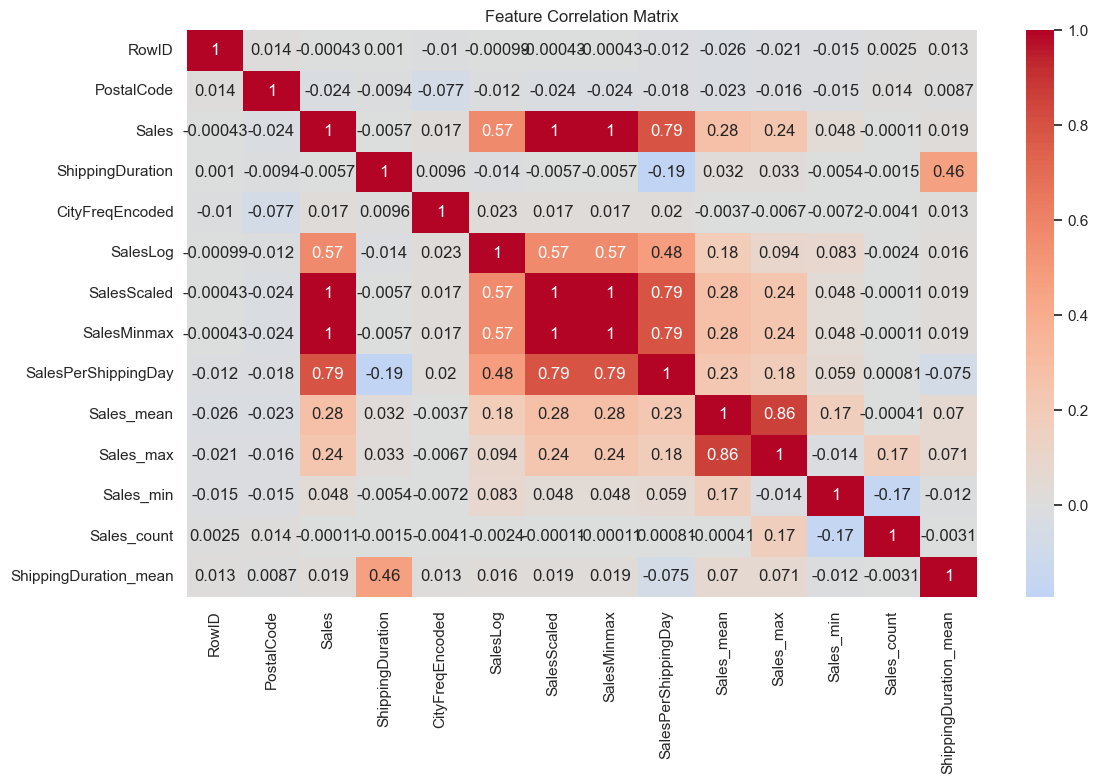

In [12]:
# Calculate correlation matrix
corr_matrix = cleaned_data.select_dtypes(include=['float64', 'int64']).corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.savefig('outputs/correlation_matrix.png')
plt.show()

In [13]:
# Select top correlated features with Sales
top_features = corr_matrix['Sales'].sort_values(ascending=False).index.tolist()
print("Top features correlated with Sales:")
print(top_features[:10])

Top features correlated with Sales:
['SalesScaled', 'SalesMinmax', 'Sales', 'SalesPerShippingDay', 'SalesLog', 'Sales_mean', 'Sales_max', 'Sales_min', 'ShippingDuration_mean', 'CityFreqEncoded']


In [14]:
cleaned_data.columns

Index(['RowID', 'OrderID', 'OrderDate', 'ShipDate', 'ShipMode', 'CustomerID',
       'CustomerName', 'Segment', 'Country', 'City', 'State', 'PostalCode',
       'Region', 'ProductID', 'Category', 'SubCategory', 'ProductName',
       'Sales', 'OrderYear', 'OrderMonth', 'OrderDay', 'OrderWeekday',
       'OrderQuarter', 'ShippingDuration', 'ShipModeFirstClass',
       'ShipModeSameDay', 'ShipModeSecondClass', 'ShipModeStandardClass',
       'SegmentEncoded', 'CityFreqEncoded', 'SalesLog', 'SalesBinned',
       'SalesScaled', 'SalesMinmax', 'SalesPerShippingDay', 'Sales_mean',
       'Sales_max', 'Sales_min', 'Sales_count', 'ShippingDuration_mean'],
      dtype='object')

## 6. Final Processing

In [15]:
# Select features to keep
keep_columns = [
    # Original features
    'CustomerID', 'Category', 'SubCategory',
    # Date features
    'OrderYear', 'OrderMonth', 'OrderWeekday', 'ShippingDuration',
    # Encoded features
    'ShipModeFirstClass', 'ShipModeSecondClass',
    'ShipModeStandardClass', 'SegmentEncoded', 'CityFreqEncoded',
    # Transformed features
    'SalesLog', 'SalesScaled', 'SalesBinned',
    # Created features
    'SalesPerShippingDay', 
    # Aggregated features
    'Sales_mean', 'Sales_count', 'ShippingDuration_mean',
    # Target
    'Sales'
]

In [16]:
# Filter columns
final_cols = [col for col in keep_columns if col in cleaned_data.columns]
final_data = cleaned_data[final_cols].copy()

# Handle any remaining missing values
final_data = final_data.dropna()

print(f"\nFinal dataset shape: {final_data.shape}")
print("Columns:", final_data.columns.tolist())


Final dataset shape: (9789, 20)
Columns: ['CustomerID', 'Category', 'SubCategory', 'OrderYear', 'OrderMonth', 'OrderWeekday', 'ShippingDuration', 'ShipModeFirstClass', 'ShipModeSecondClass', 'ShipModeStandardClass', 'SegmentEncoded', 'CityFreqEncoded', 'SalesLog', 'SalesScaled', 'SalesBinned', 'SalesPerShippingDay', 'Sales_mean', 'Sales_count', 'ShippingDuration_mean', 'Sales']


In [17]:
# Save processed data
final_data.to_csv('data/processed_sales_data.csv', index=False)
print("\n💾 Processing complete! Data saved to 'data/processed_sales_data.csv'")


💾 Processing complete! Data saved to 'data/processed_sales_data.csv'
